# Практическое задание к уроку 1 (2 неделя).
## Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации Shift+Tab. Нажатие Tab после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [2]:
# (0 баллов)
# Считайте данные и выведите первые 5 строк
df=pd.read_csv("bikes_rent.csv")
df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12 (соответственно январь---декабрь)
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6 (соответственно понедельник---воскресенье)
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _workthersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. Давайте посмотрим на графиках, как целевой признак зависит от остальных

/Users/a1/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


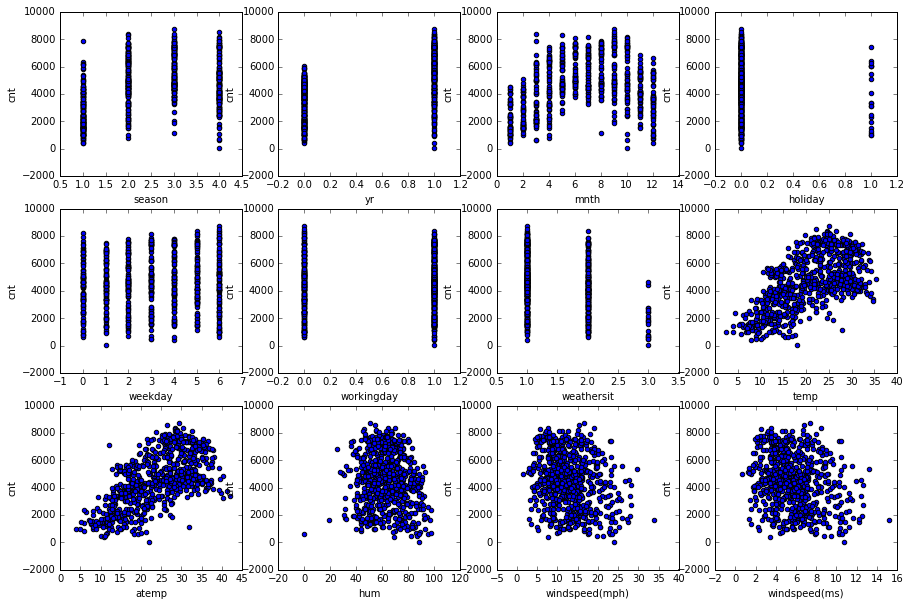

In [3]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx / 4, idx % 4])

__Блок 1. Ответьте на вопросы (каждый 0.25 балла):__
1. Каков характер зависимости числа прокатов от месяца? 
   * ответ: в теплые месяцы число прокатов больше
1. В какие дни: рабочие или выходные, людям чаще нужен велосипед?
   * ответ: разницы почти нет, в выходные нужен чуть больше.
1. В каком году прокат велосипедов был популярнее? 
   * ответ: 2012
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
   * ответ: temp, atemp

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [4]:
# Код 1.1 (0.5 балла)
# Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:
df.ix[:,0:12].corrwith(df["cnt"])

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [30]:
# Код 1.2 (0.5 балла)
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:
df.ix[:,7:13].corr()


,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [6]:
# Код 1.3 (0.5 балла)
# Выведите средние признаков

# binary
print("Binary: ", df["workingday"].mean(), df["yr"].mean(), df["holiday"].mean())

# all
df.mean()

Binary:  0.6839945280437757 0.5006839945280438 0.028727770177838577


season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на дисперсию. Это можно сделать с помощью метода scale:

In [7]:
from sklearn.preprocessing import scale

In [8]:
X = scale(df[df.columns[:-1]])
y = df["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [9]:
from sklearn.linear_model import LinearRegression
#from sklearn import datasets, linear_model

In [10]:
# Код 2.1 (1 балл)
# Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели 
# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python
# Названия признаков хранятся в переменной df.columns


# Create linear regression object
regr = LinearRegression()

# Train the model using the sets
regr.fit(X, y)

# The coefficients
print('Coefficients: \n', regr.coef_, "\n")
print('Feature:  Weight:')
      
for feature, coeff in zip(df.columns,regr.coef_.T):
    print(feature, coeff)

Coefficients: 
 [  5.70872139e+02   1.02197001e+03  -1.41308189e+02  -8.67541011e+01
   1.37223510e+02   5.63921218e+01  -3.30226150e+02   3.67487655e+02
   5.85541888e+02  -1.45611765e+02   1.24604278e+13  -1.24604278e+13] 

Feature:  Weight:
season 570.872139061
yr 1021.97000587
mnth -141.308189083
holiday -86.7541010698
weekday 137.223509616
workingday 56.3921217717
weathersit -330.226149782
temp 367.487655095
atemp 585.541888233
hum -145.611765359
windspeed(mph) 1.24604278292e+13
windspeed(ms) -1.24604278294e+13


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_, вы обсуждали ее на лекции.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge. Подробнее об этом также рассказано в лекции.

Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [11]:
from sklearn.linear_model import Lasso, Ridge

In [12]:
# Код 2.2 (0.5 балла)
# Обучите линейную модель с L1-регуляризацией
regrL = Lasso()

# Train the model using the sets
regrL.fit(X, y)

# The coefficients
print('Coefficients: \n', regrL.coef_)

Coefficients: 
 [  5.60241616e+02   1.01946349e+03  -1.28730627e+02  -8.61527813e+01
   1.37347894e+02   5.52123706e+01  -3.32369857e+02   3.76363236e+02
   5.76530794e+02  -1.44129155e+02  -1.97139689e+02  -2.80412806e-08]


In [13]:
# Код 2.3 (0.5 балла)
# Обучите линейную модель с L2-регуляризацией
regrR = Ridge()

# Train the model using the sets
regrR.fit(X, y)

# The coefficients
print('Coefficients: \n', regrR.coef_)

Coefficients: 
 [  563.06457225  1018.94837879  -131.87332028   -86.746098     138.00511118
    55.90311038  -332.3497885    386.45788919   566.34704706  -145.0713273
   -99.25944108   -99.25944115]


__Блок 2. Поясните,__ каким образом введение регуляризации решает проблему с весами и мультиколлинеарностью.

__Ваш ответ (1 балл)__: С помощью коэффициента регуляризации α можно уменьшить большие по модулю веса при линейно-зависимых признаках. Для устранения мультиколлинеарности используется отбор признаков. Устранение мультиколлинеарных факторов из модели регрессии является одним из методов повышения точности прогноза.С другой стороны при регуляризации алгоритм содержит параметры, которые необходимо оценивать дополнительно. 

### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение последнему факту было дано на лекции (всё из-за ромбообразных линий уровня L1-нормы).

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$ (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [14]:
# Код 3.1 (1 балл)
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso (вспомните встроенную в python функцию enumerate),
# а затем обучите Ridge и запишите веса в coefs_ridge.

for i, a in enumerate(alphas):
    
    regrL = Lasso(alpha=a)

    # Train the model using the sets
    regrL.fit(X, y)

    # The coefficients
    weights=regrL.coef_
    
    for j, weight in enumerate(weights):
        coefs_lasso[i,j]=weight
        
for i, a in enumerate(alphas):
    
    regrR = Ridge(alpha=a)

    # Train the model using the sets
    regrR.fit(X, y)

    # The coefficients
    weights=regrR.coef_
    
    for j, weight in enumerate(weights):
        coefs_ridge[i,j]=weight


Визуализируем динамику весов при увеличении параметра регуляризации:

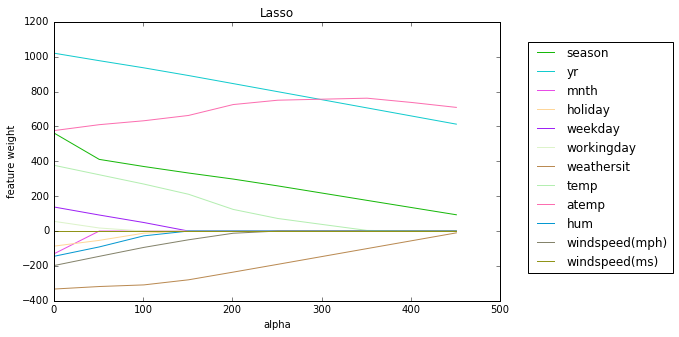

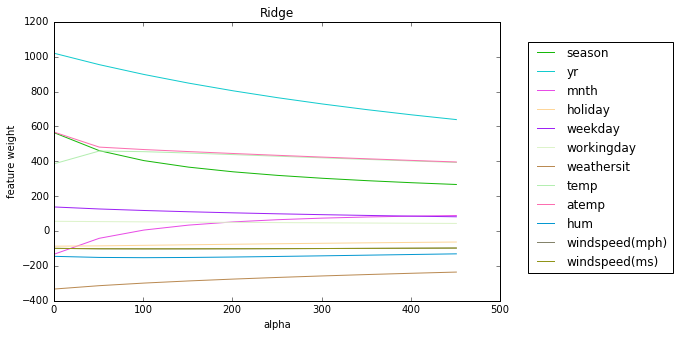

In [15]:
plt.figure(figsize=(8, 5))

colors=[]
for feature in df.columns:
    colors.append(np.random.rand(3))

for coef, feature, color in zip(coefs_lasso.T, df.columns, colors):
    plt.plot(alphas, coef, label=feature, color=color)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature, color in zip(coefs_ridge.T, df.columns,colors):
    plt.plot(alphas, coef, label=feature, color=color)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [16]:
from sklearn.linear_model import LassoCV

alpha= 26

Feature:  Weight:
season 570.872139061
yr 1021.97000587
mnth -141.308189083
holiday -86.7541010698
weekday 137.223509616
workingday 56.3921217717
weathersit -330.226149782
temp 367.487655095
atemp 585.541888233
hum -145.611765359
windspeed(mph) 1.24604278292e+13
windspeed(ms) -1.24604278294e+13


array([[  753267.23026045,   700671.76274272,  1718461.08097625],
       [  746432.58657038,   695298.35222319,  1681896.07732212],
       [  740576.6213261 ,   690075.95134416,  1643966.8337877 ],
       [  735658.0746776 ,   683644.40198393,  1607573.66109515],
       [  731676.92099974,   675575.35991939,  1572772.15185076],
       [  728633.3699757 ,   667553.6575921 ,  1538270.21035084],
       [  726527.60063013,   659786.215239  ,  1505509.64556554],
       [  725359.76427163,   652291.03276507,  1474490.39304935],
       [  725129.98859493,   645068.25886666,  1445212.45243286],
       [  725838.3812339 ,   638117.98847422,  1417675.82371411],
       [  727485.03281523,   631440.2820496 ,  1391880.50689309],
       [  730070.01957267,   625492.4295994 ,  1367826.49508556],
       [  733593.40557781,   627919.06051988,  1344863.98875199],
       [  738055.24463873,   634129.98784559,  1323605.34605572],
       [  744411.63104751,   644090.1887887 ,  1304099.68703305],
       [  

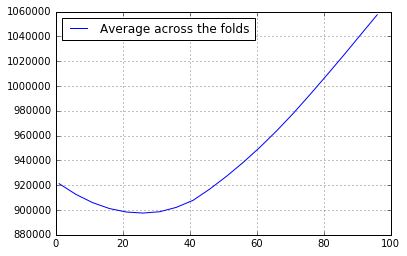

In [17]:
# Код 3.2 (1 балл)
# Обучите регрессор LassoCV на всех параметрах регуляризации из alpha
# Постройте график _усредненного_ по строкам MSE в зависимости от alpha. 
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
alphas = np.arange(1, 100, 5)

model = LassoCV(alphas=alphas).fit(X, y)


plt.plot(model.alphas_, model.mse_path_.mean(axis=1), 
         label='Average across the folds')
plt.grid(True)
plt.legend(loc='upper left')

print("alpha=", model.alpha_)

regrL = Lasso(alpha=model.alpha_)

# Train the model using the sets
regrL.fit(X, y)

# The coefficients
weights=regrL.coef_

print('\nFeature:  Weight:')
      
for feature, coeff in zip(df.columns,regr.coef_.T):
    print(feature, coeff)

model.mse_path_

alphas_min_columns= [56 41  1]


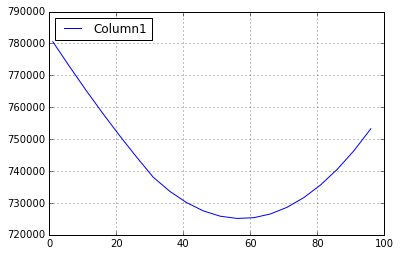

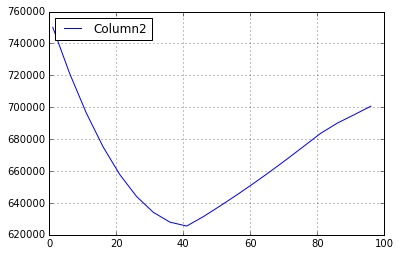

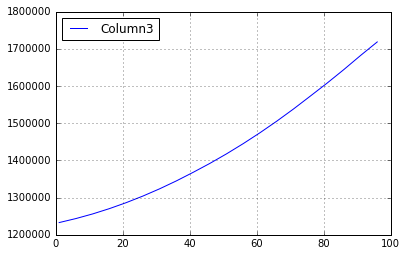

In [24]:
# Код 3.3 (1 балл)
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируйте столбцы .mse_path_

index_mins = model.mse_path_.argmin(axis=0)
print("alphas_min_columns=", model.alphas_[index_mins])

for i in range(3):
    plt.plot(model.alphas_, model.mse_path_[:,i], label='Column'+ str(i+1))
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.show()


Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

In [29]:
zipped=zip(df.columns,regrL.coef_.T)

import operator
sorted(zipped, key=operator.itemgetter(1))

[('weathersit', -323.67910842163866),
 ('windspeed(mph)', -170.44942053622722),
 ('hum', -122.41739716302786),
 ('holiday', -71.475853467463949),
 ('windspeed(ms)', -2.2574798165783592e-08),
 ('mnth', -0.0),
 ('workingday', 36.831355314954465),
 ('weekday', 113.41239026287381),
 ('temp', 348.31239784094117),
 ('season', 431.50501463394625),
 ('atemp', 599.39149098211283),
 ('yr', 997.59495798591058)]

__Блок 4. Ответьте на вопросы (каждый 0.5 балла):__
1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами, посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 

     * Ответ: 4 наибольших по модулю признаков такие:
     
     ('temp', 348.31239784094117),
     ('season', 431.50501463394625),
     ('atemp', 599.39149098211283),
     ('yr', 997.59495798591058)]
     Не для этих признаков видна всех видна возрастающая линейная зависимость. Для признака season такой зависимости нет.
     Для признаков temp и atemp логично  утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды.
          
1. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами, посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
   
   * Ответ: 3 признака с наибольшими по модулю отрицательными коэффициентами такие:
   
     ('weathersit', -323.67910842163866),
     ('windspeed(mph)', -170.44942053622722),
     ('hum', -122.41739716302786)
     Не видна убывающая линейная зависимость ни для одного из этих признаков.
     Логично утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды. В плохую погоду желание брать велосипед меньше.    
     
1. Выберите признаки с нулевыми коэффициентами. Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

    * Ответ: Признаки с нулевыми коэффициентами: ('mnth', -0.0)
     Метод Lasso вводит ограничения на норму вектора коэффициентов модели, что приводит к обращению в ноль некоторых коэффициентов модели. Метод приводит к повышению устойчивости модели, позволяет отбирать признаки, оказывающие наибольшее влияние на вектор ответов.
    Хотя странно, что модель исключила этот признак (он имеет коэффициент корреляции с признаком cnt 0.279977).
    По-моему (из здравого смысла), он влияет на спрос на велосипеды. Чем теплее тем больше берут велосипеды.

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.